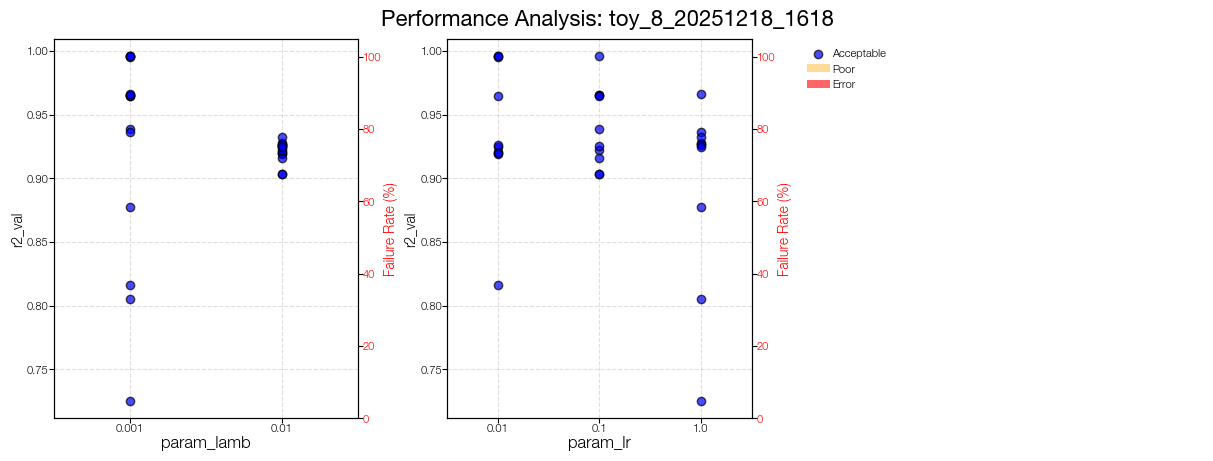

In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from kan.experiments.multkan_hparam_sweep import plot_parameter_performance

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

root_dir = os.path.join(os.getcwd())
save_dir = os.path.join(root_dir, "custom_figures", "toy8")
os.makedirs(save_dir, exist_ok=True)

f_param = "toy_8_20251218_1618"
save_heading = os.path.join(save_dir, f_param + "_analysis")
load_heading = os.path.join(root_dir, 'multkan_sweep_autosave', f_param)

d_opt = pd.read_excel(load_heading + ".xlsx", sheet_name='best_avg_by_params')
d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()

plot_parameter_performance(f_param, root_dir)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
feature_range = (0.1, 0.9)

name_X = ["x1", "x2"]
name_y = "y"

x1_grid = np.linspace(-1, 1, 40)
x2_grid = np.linspace(-1, 1, 40)

x1, x2 = np.meshgrid(x1_grid, x2_grid)
X = np.stack((x1.flatten(), x2.flatten()), axis=1)
y = x1 ** 2 / (x2 + 1.08) / 1.8
y = y.flatten().reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"테스트셋 크기: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

scaler_X = MinMaxScaler(feature_range=feature_range)
scaler_y = MinMaxScaler(feature_range=feature_range)

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)
# dataset = {
#     'train_input': torch.tensor(X_train_norm, dtype=torch.float32, device=device),
#     'train_label': torch.tensor(y_train_norm, dtype=torch.float32, device=device),
#     'test_input': torch.tensor(X_test_norm, dtype=torch.float32, device=device),
#     'test_label': torch.tensor(y_test_norm, dtype=torch.float32, device=device),
#     'val_input': torch.tensor(X_val_norm, dtype=torch.float32, device=device),
#     'val_label': torch.tensor(y_val_norm, dtype=torch.float32, device=device),
# }

전체 데이터셋 크기: 1600
훈련셋 크기: 1024 (64.0%)
검증셋 크기: 256 (16.0%)
테스트셋 크기: 320 (20.0%)


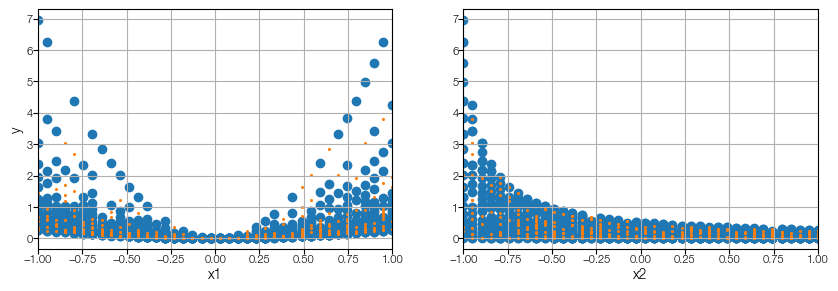

In [4]:
import matplotlib.pyplot as plt

num_input = X.shape[1]
fig, axs = plt.subplots(1, num_input, figsize=(10, 3))
for i in range(num_input):
    ax = axs[i]
    ax.scatter(X_train[:, i], y_train)
    ax.scatter(X_test[:, i], y_test, s=1.5)
    ax.set_xlabel(name_X[i])
    ax.grid()
axs[0].set_ylabel(name_y)
plt.show()

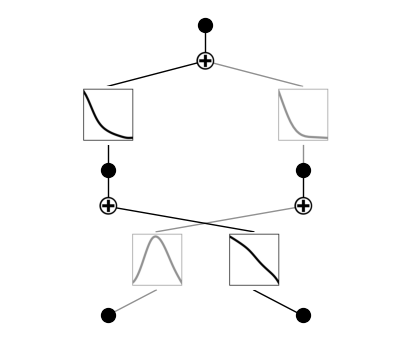

In [5]:
from kan.custom_multkan_ddp import KAN

model = KAN.loadckpt(path=load_heading+"_model")
model.plot()

{'grid_range': (0.1, 0.9), 'lamb': 0.001, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.5, 'lamb_entropy': 0.1, 'lr': 0.1, 'prune': True, 'pruning_th': 0.05, 'stop_grid_update_step': 20, 'width': '[[2, 0], [2, 0], [1, 0]]'}
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,0,0) with 0
r2 is 0.9949404001235962
fixing (0,0,1) with gaussian, r2=0.99, c=3
r2 is 0.9989521503448486
fixing (0,1,0) with gaussian, r2=1.0, c=3
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,1,1) with 0
r2 is 0.9996705055236816
fixing (1,0,0) with arctan, r2=1.0, c=4
r2 is 0.9770357608795166
fixing (1,1,0) with gaussian, r2=1.0, c=3


| train_loss: 6.84e-02 | test_loss: 5.08e-02 | reg: 1.91e-01 | : 100%|█| 50/50 [00:05<00:00,  8.73it


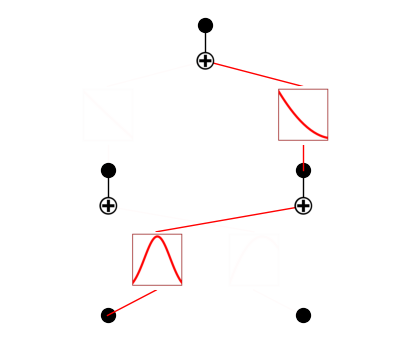

-0.1563*atan(5.5701 + 9.3121*exp(-0.3462*(0.6298 - x_2)**2)) + 1.5076 - 1.1718*exp(-0.1263*(1 - 0.9147*exp(-11.4841*(0.5015 - x_1)**2))**2)

In [6]:
from kan.utils import ex_round
from kan.experiments.multkan_hparam_sweep import get_arg_dict, _seed_everything

params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}
params['grid_range'] = feature_range
print(params)

_seed_everything(0)
device, model_kwargs, fit_kwargs, dataset = get_arg_dict((X_train_norm, y_train_norm, X_val_norm, y_val_norm, X_test_norm, y_test_norm, params, device.type, scaler_y, 0))
model.auto_symbolic(weight_simple=0, a_range=(-50,50), b_range=(-50,50))
model.fit(dataset, **fit_kwargs)
model.plot()
plt.show()
ex_round(model.symbolic_formula()[0][0], 4)

{'train': 0.21074371105909262, 'test': 0.26676446931266296}


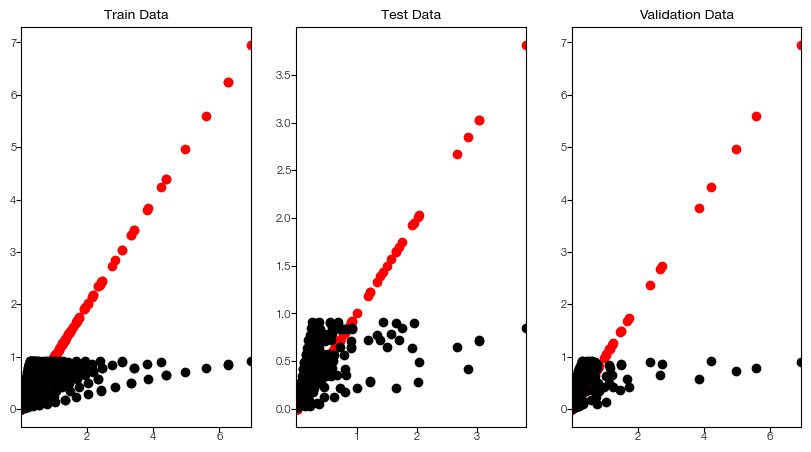

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_norm_test = model.forward(x=dataset['test_input']).detach().cpu().numpy()
y_pred_norm_train = model.forward(x=dataset['train_input']).detach().cpu().numpy()
y_pred_norm_val = model.forward(x=dataset['val_input']).detach().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_norm_test)
y_pred_train = scaler_y.inverse_transform(y_pred_norm_train)
y_pred_val = scaler_y.inverse_transform(y_pred_norm_val)
# y_train = dataset['train_label']
# y_test = dataset['test_label']

r2_score = {
    "train": r2_score(y_train, y_pred_train),
    "test": r2_score(y_test, y_pred_test),
}
print(r2_score)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax_train = ax[0]
ax_train.scatter(y_train, y_train, color='r')
ax_train.scatter(y_train, y_pred_train, color='k')
ax_train.set_title("Train Data")

ax_test = ax[1]
ax_test.scatter(y_test, y_test, color='r')
ax_test.scatter(y_test, y_pred_test, color='k')
ax_test.set_title("Test Data")

ax_test = ax[2]
ax_test.scatter(y_val, y_val, color='r')
ax_test.scatter(y_val, y_pred_val, color='k')
ax_test.set_title("Validation Data")

plt.show()
plt.show()

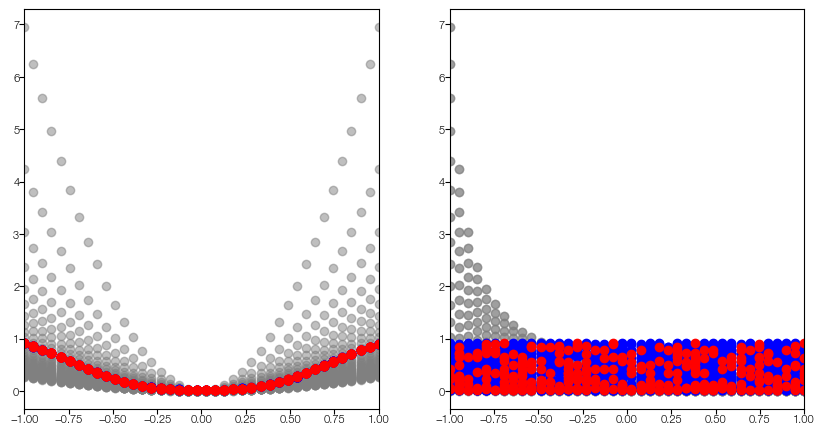

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(num_input):
    ax = axs[i]
    ax.scatter(X[:,i], y, c='gray', alpha=0.5)
    ax.scatter(X_train[:, i], y_pred_train, c='b', label='Train')
    ax.scatter(X_test[:, i], y_pred_test, c='r', label='Test')